## Import Necessary Libraries

In [40]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates


## Importing the DataSet

In [10]:
customers = pd.read_csv('/content/Customers.csv')
transactions = pd.read_csv('/content/Products.csv')
products = pd.read_csv('/content/Transactions.csv')


In [11]:
customers.head(), transactions.head(), products.head()

(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
   ProductID              ProductName     Category   Price
 0      P001     ActiveWear Biography        Books  169.30
 1      P002    ActiveWear Smartwatch  Electronics  346.30
 2      P003  ComfortLiving Biography        Books   44.12
 3      P004            BookWorld Rug   Home Decor   95.69
 4      P005          TechPro T-Shirt     Clothing  429.31,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55    

## Merge DataSet

In [17]:
data = pd.merge(customers, products, on='CustomerID')
customer_transactions = pd.merge(data, transactions, on='ProductID')


In [18]:
customer_transactions.head()

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30,SoundWave Cookbook,Books,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54,HomeSense Wall Art,Home Decor,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47,SoundWave Headphones,Electronics,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72,ActiveWear Smartwatch,Electronics,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64,TechPro Headphones,Electronics,433.64


## Calculating Customer Spending Metrics by Region

In [37]:
customer_transactions['TotalSpending'] = customer_transactions['Quantity'] * customer_transactions['Price_y']
customer_features = customer_transactions.groupby(['CustomerID', 'Region']).agg(
    TotalSpending=('TotalSpending', 'sum'),
    Frequency=('TransactionID', 'count'),
    AvgTransactionValue=('TotalValue', 'mean'),
).reset_index()

print(customer_features.columns)

Index(['CustomerID', 'Region', 'TotalSpending', 'Frequency',
       'AvgTransactionValue'],
      dtype='object')


## Preparing Data for Customer Segmentation

In [38]:
numerical_features = customer_features.select_dtypes(include=['number'])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(numerical_features)

In [39]:
scaled_features_df = pd.DataFrame(scaled_features, columns=numerical_features.columns, index=numerical_features.index)
final_customer_features = pd.concat([customer_features['CustomerID'], scaled_features_df], axis=1)

## Customer Segmentation using K-Means

In [42]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)
customer_features['Cluster'] = cluster_labels

db_index = davies_bouldin_score(scaled_features, cluster_labels)
silhouette_avg = silhouette_score(scaled_features, cluster_labels)

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")

Davies-Bouldin Index: 0.8524813520458038
Silhouette Score: 0.3535127066812944


## Visualizing Customer Segments

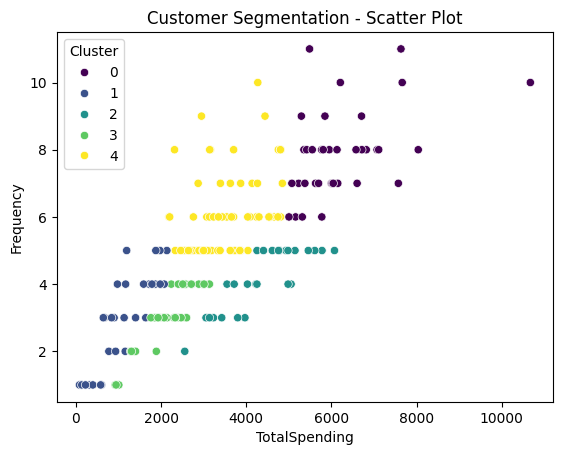

In [43]:
sns.scatterplot(x='TotalSpending', y='Frequency', hue='Cluster', data=customer_features, palette='viridis')
plt.title('Customer Segmentation - Scatter Plot')
plt.show()

<ipython-input-45-c0c4578ca180>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=customer_features, palette='viridis')
<ipython-input-45-c0c4578ca180>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=customer_features, palette='viridis')
<ipython-input-45-c0c4578ca180>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=customer_features, palette='viridis')


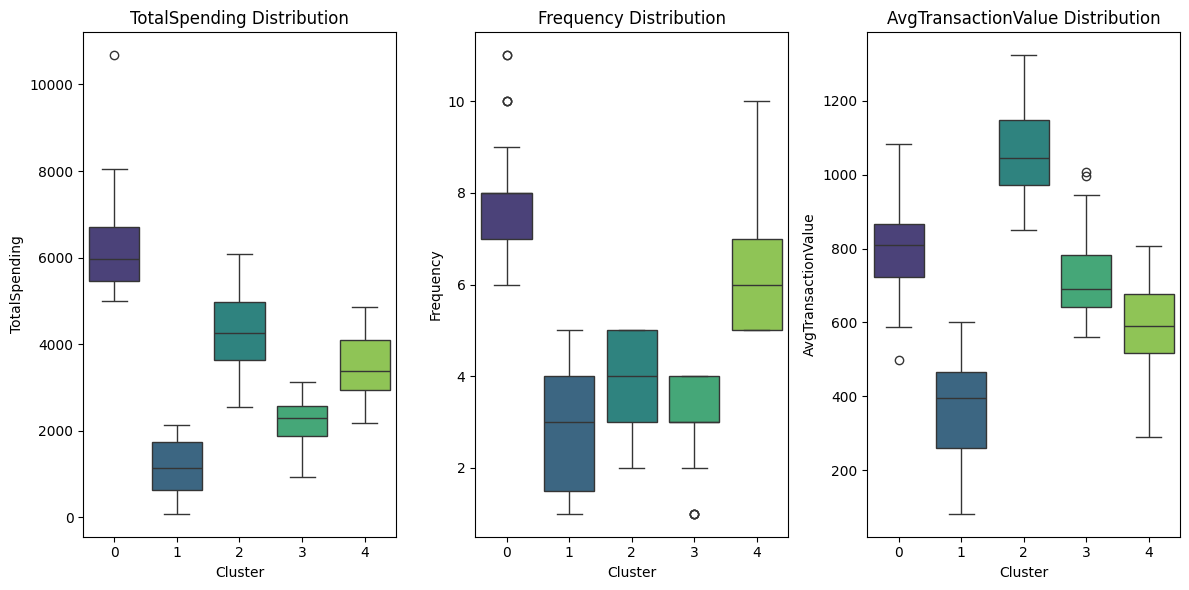

In [45]:
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    sns.boxplot(x='Cluster', y=feature, data=customer_features, palette='viridis')
    plt.title(f'{feature} Distribution')
plt.tight_layout()
plt.show()